In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textwrap
import os
import matplotlib.patches as patches
import matplotlib.colors as mcolors

In [2]:
# !!! Modify this to match the name of the csv file of the patients you generated
file_path = "llm_patients_040725.csv"

In [3]:
# !!! Modify this to specify what folder you would like your plots to go into
OUTPUT_DIR = "plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
# =============================================================================
# Hard-coded Demographic Distributions
# =============================================================================

""" This data is the same as the demographic distributions from the llm_patient_creator.ipynb file. """
# split distributions to a .py file?

# Age distribution (averaged for men & women).
AGE_WEIGHTS_MEN = [0.2979, 0.1916, 0.1557, 0.2266, 0.1282]
AGE_WEIGHTS_WOMEN = [0.2861, 0.1683, 0.1483, 0.2343, 0.1630]

# Relationship status percentages by age group: (18-25, 26-35, 36-45, 46-60, 60+)
RELATIONSHIP_STATUS_DISTRIBUTIONS = [
    [69.26, 23.09,  7.40,  0.25,  0.00],  # 18-25
    [31.73, 10.58, 55.35,  2.15,  0.20],  # 26-35
    [10.88,  3.63, 76.00,  8.15,  1.35],  # 36-45
    [ 9.00,  3.00, 68.33, 15.33,  8.17],  # 46-60
    [11.25,  3.75, 54.17,  8.83, 33.50],  # 60+
]

# Probabilities of being "in a family" & "with children," by 4 age bins (0-24, 25-34, 35-44, 45-54).
IN_FAMILY = [
    [0.0756, 0.0701],  # female, male (0-24)
    [0.5102, 0.4765],  # female, male (25-34)
    [0.8340, 0.8178],  # female, male (35-44)
    [0.8426, 0.8557],  # female, male (45+)
]
WITH_CHILDREN = [
    [0.6997, 0.3003],  # yes, no  (0-24)
    [0.5193, 0.4807],  # yes, no  (25-34)
    [0.2056, 0.7944],  # yes, no  (35-44)
    [0.1771, 0.8229],  # yes, no  (45+)
]

SEX_WEIGHTS = [0.49, 0.51]
SEX_LABELS = ["Male", "Female"]

AGE_ORDER = ["18-25", "26-35", "36-45", "46-60", "60+"]

RELATIONSHIP_ORDER = ["Single", "Long-term relationship",
                          "Married/Common-Law", "Divorced/Separated", "Widowded"]


DISABILITY_CATEGORIES = [
        "Mental-health related", "Pain-related", "Seeing",
        "Learning", "Memory", "Mobility", "Flexibility",
        "Hearing", "Dexterity", "Developmental"
    ]

ETHNICITY_CATEGORIES = {
    "Indigenous": [
        "English - Canada", "English - United States",
        "English - United Kingdom", "English - Ireland"
    ],
    "Middle Eastern": ["Persian - Iran", "Hebrew - Israel"],
    "European": [
        "Czech - Czech Republic", "Danish - Denmark", "German - Austria",
        "German - Switzerland", "German - Germany", "Greek - Greece",
        "Spanish - Spain", "Finnish - Finland", "French - Canada",
        "French - Switzerland", "French - France", "Croatian - Croatia",
        "Hungarian - Hungary", "Armenian - Armenia", "Italian - Italy",
        "Dutch - Belgium", "Dutch - Netherlands", "Norwegian - Norway",
        "Polish - Poland", "Portuguese - Portugal", "Romanian - Romania",
        "Russian - Russia", "Slovak - Slovakia", "Swedish - Sweden",
        "Ukrainian - Ukraine"
    ],
    "East Asian": [
        "Japanese - Japan", "Korean - South Korea",
        "Chinese - China", "Chinese - Taiwan"
    ],
    "South Asian": [
        "English - India", "Hindi - India", "Nepali - Nepal",
        "Tamil - India", "Bengali - Bangladesh", "English - Bangladesh",
        "Georgian - Georgia", "Azerbaijani - Azerbaijan"
    ],
    "Southeast Asian": [
        "English - Malaysia", "English - Philippines", "Filipino - Philippines",
        "Indonesian - Indonesia", "Thai - Thailand", "Tagalog - Philippines",
        "Vietnamese - Vietnam"
    ],
    "Latin American": [
        "Spanish - Argentina", "Spanish - Chile", "Spanish - Colombia",
        "Spanish - Mexico", "Portuguese - Brazil"
    ],
    "African": ["Zulu - South Africa"],
    "Other": ["English - Australia", "English - New Zealand"],
}

In [5]:
# =============================================================================
# Basic Load and Preprocessing
# =============================================================================

def load_data(filepath: str) -> pd.DataFrame:
    """Load the CSV file (pipe-delimited)."""
    return pd.read_csv(filepath, delimiter="|")


def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply all data-cleaning steps in one place:
      - Rename columns
      - Map relationships
      - Convert columns to categories
      - Assign extended age groups
      - Convert 'Children to yes/no
      - Create 'Ethnicity_Category'
    """
    # Work on a copy to avoid modifying original
    df = df.copy()

    # Rename columns
    df.rename(columns={
        "Relationship Status": "Relationship_Status",
        "Children": "Has_Children",
    }, inplace=True)

    # Simplify relationship statuses
    relationship_mapping = {
        "Common-Law": "Married/Common-Law",
        "Married": "Married/Common-Law",
        "Divorced": "Divorced/Separated",
        "Separated": "Divorced/Separated"
    }
    df["Relationship_Status"] = df["Relationship_Status"].replace(relationship_mapping)

    # Convert certain columns to categorical
    df["Sex"] = df["Sex"].astype("category")
    df["Relationship_Status"] = df["Relationship_Status"].astype("category")

    # Convert "Has_Children" to yes/no
    df["Has_Children"] = df["Has_Children"].apply(
        lambda x: "Yes" if x != 0 else "No"
    )

    # Create extended age groups
    df["Age_Group"] = df["Age"].apply(assign_age_group_extended)

    # Categorize ethnicity
    df["Ethnicity_Category"] = df["Ethnicity"].apply(categorize_ethnicity)
    df["Ethnicity_Category"] = df["Ethnicity_Category"].astype("category")

    return df

In [6]:
# =============================================================================
# Helper Functions
# =============================================================================

def assign_age_group_extended(age: float) -> str:
    """
    Assign an extended age group (18-25, 26-35, 36-45, 46-60, 60+).
    """
    if age < 25:
        return "18-25"
    elif age < 36:
        return "26-35"
    elif age < 46:
        return "36-45"
    elif age < 61:
        return "46-60"
    else:
        return "60+"


def categorize_ethnicity(ethnicity: str) -> str:
    """Map ethnicity strings into broad categories or return 'Uncategorized'."""
    for category, values in ETHNICITY_CATEGORIES.items():
        if ethnicity in values:
            return category
    return "Uncategorized"


def compute_standard_deviations(values: np.ndarray, sample_size: int = 1000) -> list[float]:
    """
    Compute standard deviations for binomial proportions:
      variance = n * p * (1 - p)
      std = sqrt(variance) / n
    """
    stds = []
    for val in values:
        variance = sample_size * val * (1 - val)
        stds.append(np.sqrt(variance) / sample_size)
    return stds

def compute_expected_disability(row: pd.Series) -> pd.Series:
    """
    Hard-coded probability of being disabled by (sex, age),
    then distribute among 10 disability types.
    """
    # Determine sex & age
    sex = row.get("Gender", "Male")
    age = row.get("Age", 30)
    sex_idx = 0 if sex == "Male" else 1

    if age < 25:
        age_idx = 0
    elif age < 65:
        age_idx = 1
    else:
        age_idx = 2

    # Hard-coded disability probability by sex/age
    if sex_idx == 0:  # male
        disability_probability_total = [0.158, 0.211, 0.389]
    else:  # female
        disability_probability_total = [0.247, 0.269, 0.418]

    p_disabled = disability_probability_total[age_idx]

    # Hard-coded distribution across 10 types
    s = 38.6 + 61.8 + 27.4 + 20.7 + 18.2 + 39.2 + 40.3 + 20.7 + 18.4 + 5.7
    disability_probability_types = [
        38.6/s, 61.8/s, 27.4/s, 20.7/s, 18.2/s,
        39.2/s, 40.3/s, 20.7/s, 18.4/s, 5.7/s
    ]
    disability_categories = DISABILITY_CATEGORIES

    expected_values = {
        cat: p_disabled * p_type
        for cat, p_type in zip(disability_categories, disability_probability_types)
    }
    return pd.Series(expected_values)

In [7]:
# =============================================================================
# Plotting Functions
# =============================================================================

def draw_split_diagonal_cells(ax: plt.Axes,
                              observed_arr: np.ndarray,
                              expected_arr: np.ndarray,
                              cmap_obs,
                              cmap_exp,
                              norm_obs,
                              norm_exp,
                              text_size: int = 9) -> None:
    """
    Draw half a cell for observed (upper-left) and half for expected (lower-right),
    each colored by its own colormap & normalization.
    """
    n_rows, n_cols = observed_arr.shape

    for i in range(n_rows):
        for j in range(n_cols):
            # Coordinates for the cell boundaries (each cell is 1x1).
            top_left = (j, i)
            bottom_left = (j, i + 1)
            bottom_right = (j + 1, i + 1)
            top_right = (j + 1, i)

            # Observed triangle (upper-left)
            obs_val = observed_arr[i, j]
            color_obs = cmap_obs(norm_obs(obs_val))
            ax.add_patch(patches.Polygon([top_left, bottom_left, top_right],
                                         facecolor=color_obs,
                                         edgecolor="white"))
            # Expected triangle (lower-right)
            exp_val = expected_arr[i, j]
            color_exp = cmap_exp(norm_exp(exp_val))
            ax.add_patch(patches.Polygon([bottom_left, bottom_right, top_right],
                                         facecolor=color_exp,
                                         edgecolor="white"))

            # Annotations
            ax.text(j + 0.3, i + 0.3, f"{obs_val:.2f}",
                    ha="center", va="center",
                    fontsize=text_size, color="black")

            ax.text(j + 0.7, i + 0.7, f"{exp_val:.2f}",
                    ha="center", va="center",
                    fontsize=text_size, color="black")


def plot_comparison(observed: dict,
                    expected: dict,
                    title: str,
                    chart_type: str = "bar",
                    save_fig: bool = False) -> None:
    """
    Generic function to compare 'observed' vs. 'expected' data in a bar plot.
    Error bars are derived from the 'expected' distribution (binomial assumption).
    """
    categories = list(expected.keys())
    observed_vals = np.array([observed.get(cat, 0) for cat in categories])
    expected_vals = np.array([expected[cat] for cat in categories])

    # Compute standard deviations from the expected distribution
    stds = compute_standard_deviations(expected_vals, sample_size=1000)

    x_positions = np.arange(len(categories))
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    if chart_type == "bar":
        ax.bar(x_positions - bar_width/2,
               observed_vals,
               bar_width,
               color = 'blue',
               yerr=stds,
               capsize=5,
               label="Observed")

        ax.bar(x_positions + bar_width/2,
               expected_vals,
               bar_width,
               color = 'red',
               label="Expected")

    # Optionally handle other chart types (e.g., line) here...

    # Wrap x labels if they're too long
    wrapped_labels = [textwrap.fill(cat, width=13) for cat in categories]
    font_size = 14
    ax.set_xticks(x_positions)
    ax.set_xticklabels(wrapped_labels, rotation=90, fontsize=font_size)
    ax.set_ylabel("Fraction", fontsize=font_size)
    ax.set_title(title, fontsize=font_size + 2)
    ax.legend(fontsize=font_size)
    plt.tight_layout()

    if save_fig:
        filename = f"{OUTPUT_DIR}/{title.replace(' ', '_').lower()}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        print(f"Saved: {filename}")

    plt.show()


def plot_split_diagonal_heatmap(observed_df: pd.DataFrame,
                                expected_df: pd.DataFrame,
                                title: str,
                                x_label: str,
                                y_label: str,
                                save_fig: bool = False,
                                filename: str = "split_diagonal.png") -> None:
    """
    Generic function to plot a split-diagonal heatmap comparing observed_df vs. expected_df.
    The dataframes must have the same shape and aligned indices/columns.

    This wraps up:
      - Setting axes limits, ticks, labels
      - Drawing cells via draw_split_diagonal_cells
      - Adding colorbars
      - Saving if requested
    """
    if observed_df.shape != expected_df.shape:
        raise ValueError("observed_df and expected_df must have the same shape.")

    row_labels = observed_df.index.tolist()
    col_labels = observed_df.columns.tolist()

    observed_arr = observed_df.values
    expected_arr = expected_df.values

    # Determine common color scale limits (optional: you could do separate scales)
    min_val = min(observed_arr.min(), expected_arr.min())
    max_val = max(observed_arr.max(), expected_arr.max())

    cmap_obs = plt.get_cmap("Blues")
    cmap_exp = plt.get_cmap("Reds")
    norm_obs = mcolors.Normalize(vmin=min_val, vmax=max_val)
    norm_exp = mcolors.Normalize(vmin=min_val, vmax=max_val)

    n_rows, n_cols = observed_arr.shape
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, n_cols)
    ax.set_ylim(0, n_rows)
    ax.invert_yaxis()

    # Configure tick positions (center of each cell) and labels
    ax.set_xticks(np.arange(n_cols) + 0.5)
    ax.set_yticks(np.arange(n_rows) + 0.5)
    ax.set_xticklabels(col_labels, rotation=45, ha="right")
    ax.set_yticklabels(row_labels)

    # Title and axis labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Draw the actual split cells
    draw_split_diagonal_cells(ax,
                              observed_arr,
                              expected_arr,
                              cmap_obs,
                              cmap_exp,
                              norm_obs,
                              norm_exp,
                              text_size=8)

    # Adjust layout for colorbars on the right
    plt.subplots_adjust(right=0.70)

    # Observed colorbar
    cbar_obs_ax = fig.add_axes([0.75, 0.15, 0.02, 0.7])
    sm_obs = plt.cm.ScalarMappable(cmap=cmap_obs, norm=norm_obs)
    sm_obs.set_array([])
    cbar_obs = fig.colorbar(sm_obs, cax=cbar_obs_ax)
    cbar_obs.set_label("Observed", fontsize=10)

    # Expected colorbar
    cbar_exp_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    sm_exp = plt.cm.ScalarMappable(cmap=cmap_exp, norm=norm_exp)
    sm_exp.set_array([])
    cbar_exp = fig.colorbar(sm_exp, cax=cbar_exp_ax)
    cbar_exp.set_label("Expected", fontsize=10)

    if save_fig:
        out_path = os.path.join(OUTPUT_DIR, filename)
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"Saved: {out_path}")

    plt.show()

In [8]:
# =============================================================================
# Main Analysis Flow
# =============================================================================

def run_analysis(df: pd.DataFrame) -> None:
    """
    Run the various analyses (disability, gender distribution,
    age distribution, relationship status, and children) after preprocessing.
    """

    # ==========================================================================
    # DISABILITY BREAKDOWN: OBSERVED VS. EXPECTED (BAR COMPARISON)
    # ==========================================================================
    
    # 1) Compute the observed distribution
    observed_disability_counts = df["Disability"].value_counts()
    total_obs = observed_disability_counts.sum()
    observed_disability = {
        cat: observed_disability_counts.get(cat, 0) / total_obs
        for cat in DISABILITY_CATEGORIES
    }

    # 2) Compute the expected distribution by applying 'compute_expected_disability' row-wise,
    #    then averaging the results
    expected_disability_df = df.apply(compute_expected_disability, axis=1)
    expected_disability_avg = expected_disability_df.mean().to_dict()

    # 3) Render the bar chart
    plot_comparison(observed_disability,
                    expected_disability_avg,
                    "Disability Breakdown: Observed vs Expected",
                    save_fig=True)

    # ==========================================================================
    # SEX DISTRIBUTION (BAR COMPARISON)
    # ==========================================================================
    # 1) Compute observed distribution
    df_sex_counts = df["Sex"].value_counts(normalize=True)
    actual_sex_dist = pd.Series(SEX_WEIGHTS, index=SEX_LABELS)

    # 2) Plot observed vs. expected
    plot_comparison(df_sex_counts,
                    actual_sex_dist,
                    "Comparison of Sex Distribution",
                    save_fig=True)

    # ==========================================================================
    # AGE DISTRIBUTION: OBSERVED VS. EXPECTED (BAR COMPARISON)
    # ==========================================================================
    # 1) Compute the observed fraction in each age group
    observed_age_counts = df["Age_Group"].value_counts().reindex(AGE_ORDER, fill_value=0)
    observed_age_frac = observed_age_counts / observed_age_counts.sum()

    # 2) Build the expected age distribution (averaged men & women)
    actual_age = np.array([(m + w) / 2 for m, w in zip(AGE_WEIGHTS_MEN, AGE_WEIGHTS_WOMEN)])
    expected_age_dist = dict(zip(AGE_ORDER, actual_age))
    observed_age_dist = dict(observed_age_frac)

    # 3) Plot the bar chart
    plot_comparison(observed_age_dist,
                    expected_age_dist,
                    "Comparison of Age Distribution (Observed vs. Expected)",
                    save_fig=True)

    # ==========================================================================
    # RELATIONSHIP STATUS BY AGE GROUP (SPLIT-DIAGONAL HEATMAP)
    # ==========================================================================

    # 1) Compute observed fractions using crosstab (normalized by row)
    observed_rel_df = pd.crosstab(df["Age_Group"],
                                  df["Relationship_Status"],
                                  normalize="index")
    observed_rel_df = observed_rel_df.reindex(index=AGE_ORDER,
                                              columns=RELATIONSHIP_ORDER)

    # 2) Build expected distribution from hard-coded RELATIONSHIP_STATUS_DISTRIBUTIONS
    columns_for_rel = ["Single", "Long-term Relationship", "Married/Common-law",
                       "Divorced/Separated", "Widowed"]
    rel_df = pd.DataFrame(RELATIONSHIP_STATUS_DISTRIBUTIONS,
                          index=AGE_ORDER,
                          columns=columns_for_rel)

    # 3) Rename columns to match observed naming
    col_map = {
        "Long-term Relationship": "Long-term relationship",
        "Married/Common-law": "Married/Common-Law",
        "Widowed": "Widowded"
    }
    rel_df.rename(columns=col_map, inplace=True)
    expected_rel_df = rel_df.reindex(index=AGE_ORDER, columns=RELATIONSHIP_ORDER)

    # 4) Convert from percentages (0-100) to fractions (0-1)
    observed_matrix = observed_rel_df.values
    expected_matrix = expected_rel_df.values / 100.0

    # Convert the matrix form back into DataFrame (for the split-diagonal function)
    obs_df_rel = pd.DataFrame(observed_matrix,
                              index=AGE_ORDER,
                              columns=RELATIONSHIP_ORDER)
    exp_df_rel = pd.DataFrame(expected_matrix,
                              index=AGE_ORDER,
                              columns=RELATIONSHIP_ORDER)

    # 5) Plot the split-diagonal heatmap
    plot_split_diagonal_heatmap(
        observed_df=obs_df_rel,
        expected_df=exp_df_rel,
        title="Combined Relationship Status by Age Group\n(Observed vs. Expected)",
        x_label="Relationship Status",
        y_label="Age Group",
        save_fig=True,
        filename="combined_relationship_status.png"
    )

    # ==========================================================================
    # CHILDREN BY AGE & GENDER (SPLIT-DIAGONAL HEATMAP)
    # ==========================================================================
    # 1) Use the entire DataFrame (no filter for Age < 55).
    df_for_children = df.copy()  # or df_for_children = df

    # 2) Define the new bins and labels: [0,25), [25,35), [35,45), [45,∞)
    age_bins = [0, 25, 35, 45, float('inf')]
    age_labels = ['0-24', '25-34', '35-44', '45+']

    df_for_children['Age_Bin'] = pd.cut(
        df_for_children['Age'],
        bins=age_bins,
        labels=age_labels,
        right=False
    )

    # 3) Compute observed fraction with children (pivot into 2D table)
    observed_counts = (
        df_for_children.groupby(['Age_Bin', 'Sex'])['Has_Children']
                       .value_counts(normalize=True)
                       .unstack(fill_value=0)
    )
    observed_df_children = (
        observed_counts[['Yes']]  # we only need the "Yes" column
        .reset_index()
        .pivot(index='Age_Bin', columns='Sex', values='Yes')
    )

    # 4) Build the expected fraction with children
    expected_dict_children = {}
    for i, label in enumerate(age_labels):
        # Probability = in_family[i][sex_idx] * with_children[i][0]
        female_prob = IN_FAMILY[i][0] * WITH_CHILDREN[i][0]
        male_prob   = IN_FAMILY[i][1] * WITH_CHILDREN[i][0]
        expected_dict_children[(label, "Female")] = female_prob
        expected_dict_children[(label, "Male")]   = male_prob

    expected_series_children = pd.Series(expected_dict_children)
    expected_df_children = expected_series_children.unstack()

    # 5) Render the split-diagonal heatmap
    plot_split_diagonal_heatmap(
        observed_df=observed_df_children,
        expected_df=expected_df_children,
        title="Combined Fraction with Children by Age & Sex",
        x_label="Sex",
        y_label="Age Bin",
        save_fig=True,
        filename="combined_children_by_age_sex.png"
    )

Saved: plots/disability_breakdown:_observed_vs_expected.png


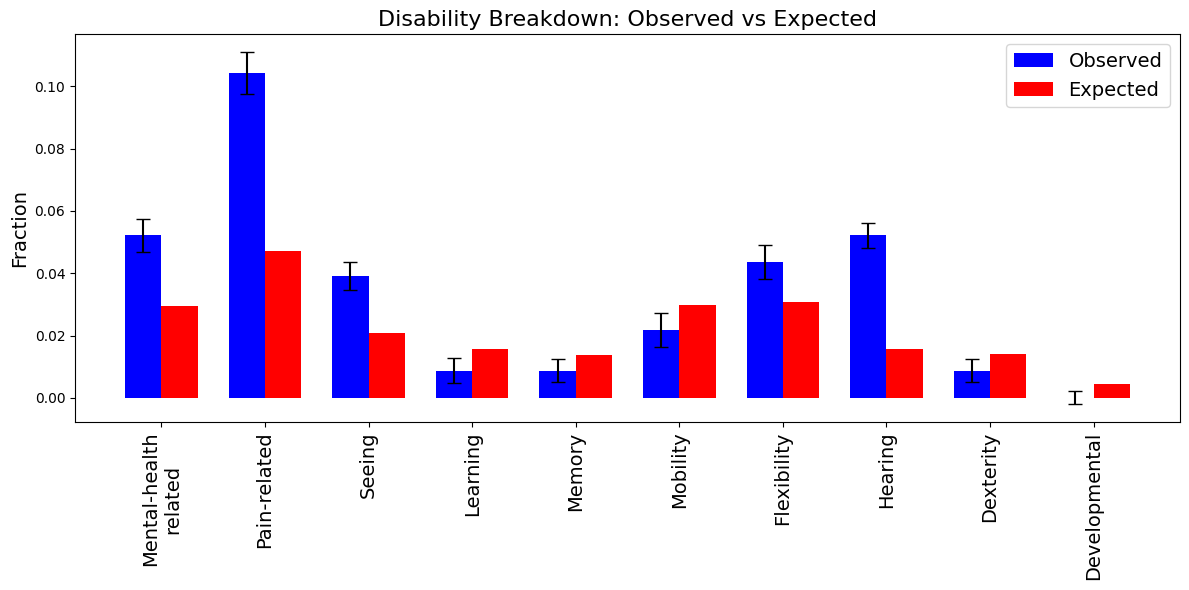

Saved: plots/comparison_of_sex_distribution.png


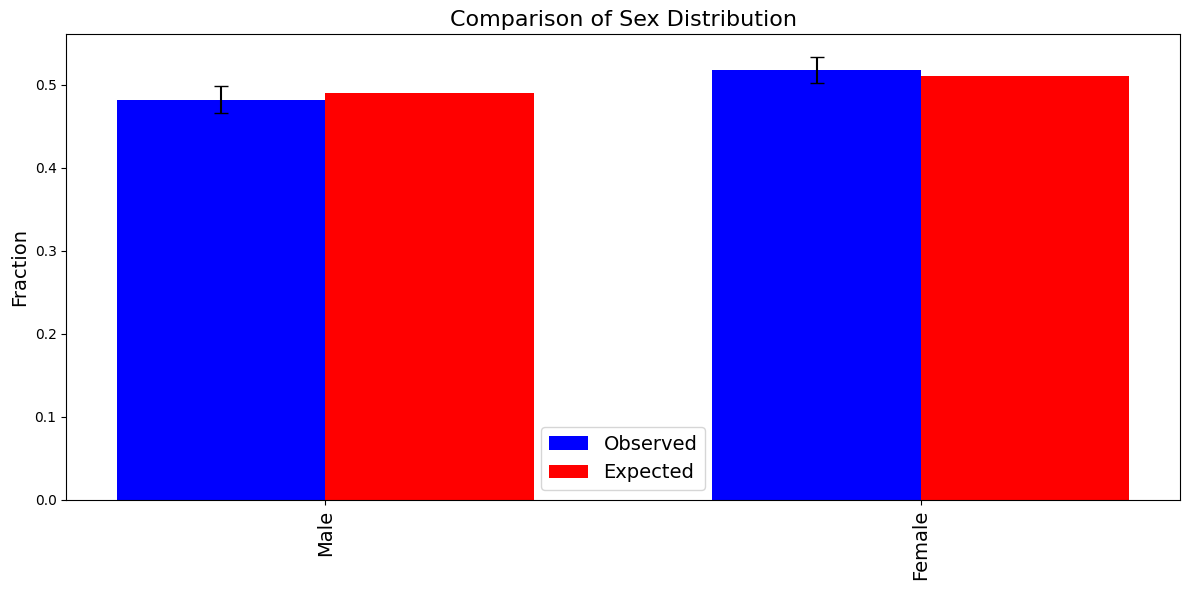

Saved: plots/comparison_of_age_distribution_(observed_vs._expected).png


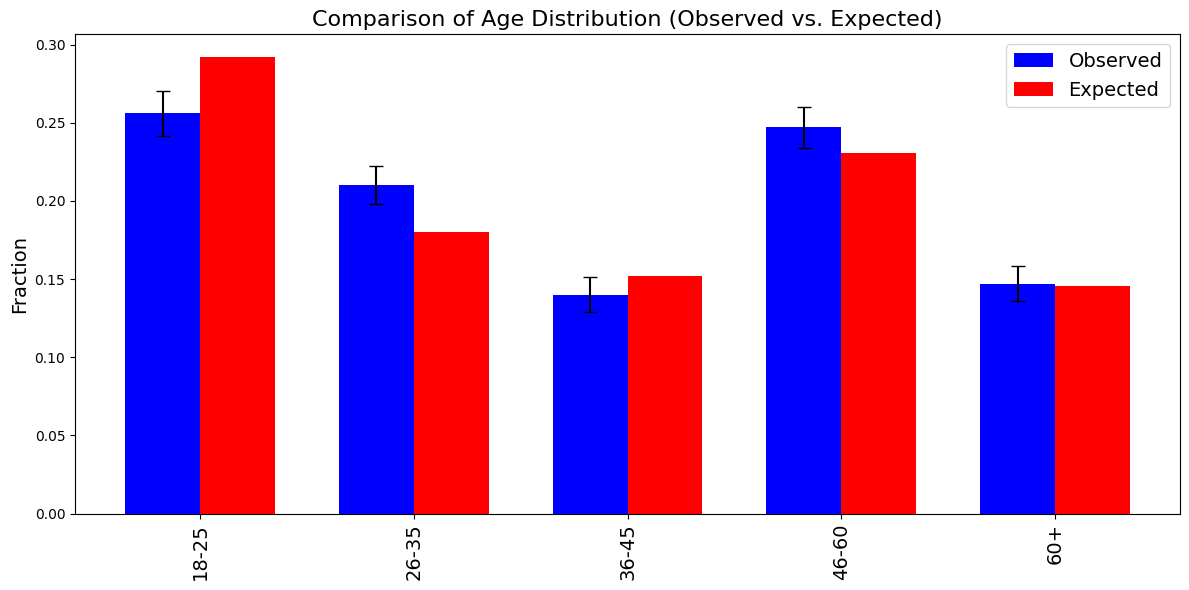

Saved: plots/combined_relationship_status.png


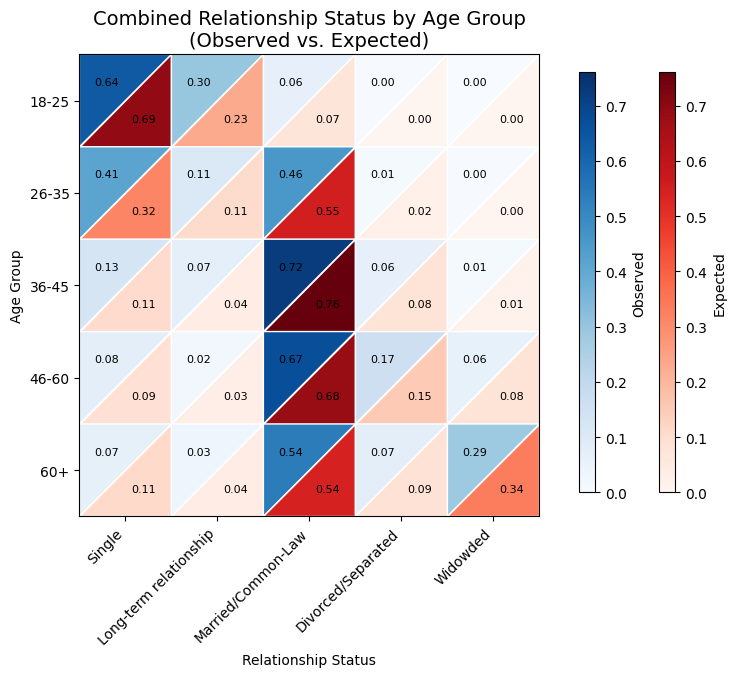

/tmp/ipykernel_1305724/1255597848.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_for_children.groupby(['Age_Bin', 'Sex'])['Has_Children']


Saved: plots/combined_children_by_age_sex.png


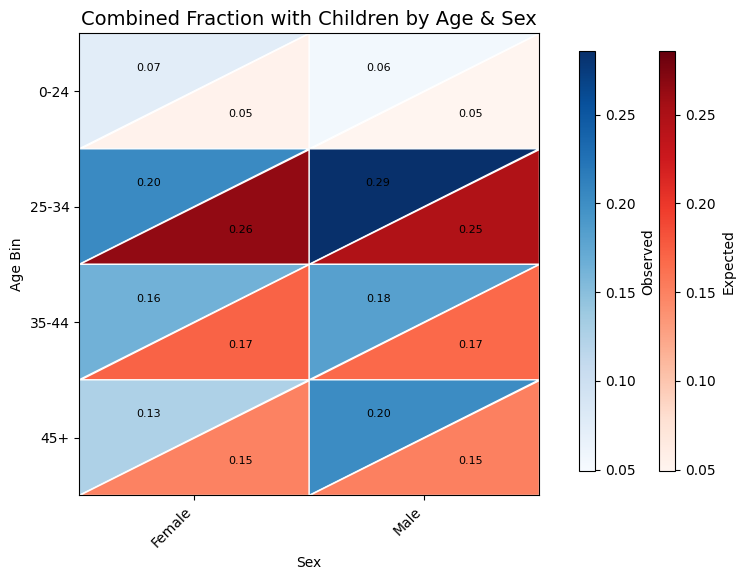

In [9]:
def main():
    """Main: load data, preprocess, then run the analysis flow."""
    file_path = "llm_patients_040725.csv"
    df = load_data(file_path)
    df = preprocess_data(df)
    run_analysis(df)


if __name__ == "__main__":
    main()

In [10]:
# # =============================================================================
# # Helper Functions
# # =============================================================================

# def compute_standard_deviations(values, sample_size=1000):
#     """
#     Compute standard deviations (for binomial proportions), print the intermediate
#     variance/std results, and return the array of standard deviations (divided by sample_size).
#     """
#     standard_devs = []
#     for i in values:
#         variance = (sample_size * i) * (1 - i)
#         standard_dev = np.sqrt(variance)
#         # Final standard dev is divided by sample_size (as in the original code)
#         standard_dev = standard_dev / sample_size
#         standard_devs.append(standard_dev)
#     return standard_devs


# def draw_split_diagonal_cells(ax,
#                               observed_arr,
#                               expected_arr,
#                               cmap_obs,
#                               cmap_exp,
#                               norm_obs,
#                               norm_exp,
#                               text_size=9):
#     """
#     Draw a "split-diagonal" heatmap where each cell is cut along the diagonal:
#       - Upper-left triangle shows observed_arr[i,j]
#       - Lower-right triangle shows expected_arr[i,j]
#     The color for each triangle is determined by its own colormap & normalization.

#     Parameters
#     ----------
#     ax : matplotlib.axes.Axes
#         The axes object on which to draw.
#     observed_arr : 2D array-like
#         Observed values matching the shape of expected_arr.
#     expected_arr : 2D array-like
#         Expected values matching the shape of observed_arr.
#     cmap_obs : matplotlib.colors.Colormap
#         Colormap for the observed data.
#     cmap_exp : matplotlib.colors.Colormap
#         Colormap for the expected data.
#     norm_obs : matplotlib.colors.Normalize
#         Normalization for the observed data.
#     norm_exp : matplotlib.colors.Normalize
#         Normalization for the expected data.
#     text_size : int
#         Font size for the annotations inside each cell.
#     """
#     n_rows, n_cols = observed_arr.shape

#     for i in range(n_rows):
#         for j in range(n_cols):
#             # Coordinates for the cell boundaries (each cell is 1x1).
#             tl = (j, i)           # top-left
#             bl = (j, i + 1)       # bottom-left
#             br = (j + 1, i + 1)   # bottom-right
#             tr = (j + 1, i)       # top-right

#             # Observed value (upper-left triangle).
#             obs_val = observed_arr[i, j]
#             color_obs = cmap_obs(norm_obs(obs_val))
#             triangle_obs = patches.Polygon([tl, bl, tr],
#                                            facecolor=color_obs,
#                                            edgecolor="white")
#             ax.add_patch(triangle_obs)

#             # Expected value (lower-right triangle).
#             exp_val = expected_arr[i, j]
#             color_exp = cmap_exp(norm_exp(exp_val))
#             triangle_exp = patches.Polygon([bl, br, tr],
#                                            facecolor=color_exp,
#                                            edgecolor="white")
#             ax.add_patch(triangle_exp)

#             # Add text annotations. Upper-left triangle text:
#             ax.text(j + 0.3, i + 0.3, f"{obs_val:.2f}",
#                     ha="center", va="center",
#                     fontsize=text_size, color="black")

#             # Lower-right triangle text:
#             ax.text(j + 0.7, i + 0.7, f"{exp_val:.2f}",
#                     ha="center", va="center",
#                     fontsize=text_size, color="black")


# def plot_comparison(observed, expected, title, chart_type="bar", save_fig=False):
#     """
#     Plot a comparison between observed and expected distributions.
#     Chart types supported: 'bar' (default) and 'line'.
#     Prints each expected value’s variance and std, then applies the
#     resulting standard deviations as error bars for the observed data.

#     observed : dict or pd.Series
#     expected : dict or pd.Series
#     title : str
#     chart_type : 'bar' or 'line'
#     save_fig : bool
#     """
#     categories = list(expected.keys())
#     obs_vals = np.array([observed.get(cat, 0) for cat in categories])
#     exp_vals = np.array([expected[cat] for cat in categories])

#     # Compute standard deviations for the expected distribution:
#     # (Original code uses these to set error bars for OBSERVED.)
#     standard_devs = compute_standard_deviations(exp_vals, sample_size=1000)

#     x = np.arange(len(categories))
#     fig, ax = plt.subplots(figsize=(12, 6))
#     width = 0.35

#     if chart_type == "bar":
#         rects1 = ax.bar(x - width / 2, obs_vals, width, label='Observed',
#                         color='blue', yerr=standard_devs, capsize=5)
#         rects2 = ax.bar(x + width / 2, exp_vals, width, label='Expected',
#                         color='#DC3220')

#         # Show numeric bars if desired (the original code does not place
#         # text above bars, so we leave it out to keep the same output).
#         for rect in rects1 + rects2:
#             _ = rect.get_height()

#     # If you had a line chart variation, you could add it here.

#     wrapped_labels = [textwrap.fill(label, width=13) for label in categories]

#     font_size = 16
#     ax.set_ylabel('Fraction', fontsize=font_size)
#     ax.set_title(title, fontsize=font_size + 2)
#     ax.set_xticks(x)
#     ax.set_xticklabels(wrapped_labels, fontsize=font_size, rotation=90)
#     ax.legend(fontsize=font_size)
#     plt.tight_layout()

#     # Save the figure as PNG
#     if save_fig:
#         filename = f"{output_dir}/{title.replace(' ', '_').lower()}.png"
#         plt.savefig(filename, dpi=300, bbox_inches="tight")
#         print(f"Saved: {filename}")

#     plt.show()


# def compute_expected_disability(row):
#     """
#     Compute the expected disability probabilities for each disability type.
#     For each patient, we first compute the probability of being disabled based on
#     age and sex, and then distribute that probability among the 10 disability types.
#     This returns a Series where each value is the expected contribution for that disability.
#     """
#     # Determine sex and age index
#     sex = row.get("Sex", "Male")
#     age = row.get("Age", 30)
#     sex_idx = 0 if sex == "Male" else 1
#     if age < 25:
#         age_idx = 0
#     elif age < 65:
#         age_idx = 1
#     else:
#         age_idx = 2

#     # Compute the probability of being disabled based on hard-coded matrices
#     if sex_idx == 0:  # Male
#         disability_probability_total = [0.158, 0.211, 0.389]
#     else:  # Female
#         disability_probability_total = [0.247, 0.269, 0.418]

#     p_disabled = disability_probability_total[age_idx]

#     # Normalize the distribution for the 10 disability types
#     s = 38.6 + 61.8 + 27.4 + 20.7 + 18.2 + 39.2 + 40.3 + 20.7 + 18.4 + 5.7
#     disability_probability_types = [
#         38.6/s, 61.8/s, 27.4/s, 20.7/s, 18.2/s,
#         39.2/s, 40.3/s, 20.7/s, 18.4/s, 5.7/s
#     ]

#     disability_categories = [
#         "Mental-health related", "Pain-related", "Seeing",
#         "Learning", "Memory", "Mobility", "Flexibility",
#         "Hearing", "Dexterity", "Developmental"
#     ]

#     expected = {
#         cat: p_disabled * prob
#         for cat, prob in zip(disability_categories, disability_probability_types)
#     }
#     return pd.Series(expected)


# def assign_age_group(age):
#     """
#     Assign a simplified age group for certain analyses.
#     For education analysis: '18-25', '25-64', '65+'.
#     """
#     if age < 25:
#         return '18-25'
#     elif age < 65:
#         return '25-64'
#     else:
#         return '65+'


# def assign_age_group_extended(age):
#     """
#     Assign an extended age group for demographic comparisons.
#     Groups: '18-25', '26-35', '36-45', '46-60', '60+'.
#     """
#     if age < 25:
#         return '18-25'
#     elif age < 36:
#         return '26-35'
#     elif age < 46:
#         return '36-45'
#     elif age < 61:
#         return '46-60'
#     else:
#         return '60+'


# def plot_children_heatmaps(df, save_fig=False):
#     """
#     Combines the observed and expected fraction with children by age group and gender into one plot.
#     Each cell is split diagonally:
#       - Upper-left triangle: observed fraction (Blues)
#       - Lower-right triangle: expected fraction (Reds)
#     Both values are formatted as decimals with two-digit precision.
#     Two separate colorbars are added on the right using dedicated axes with extra spacing.
#     """
#     # ----------------------------
#     # Define demographic model arrays:
#     # ----------------------------
#     in_family = [  # women, men
#         [0.0756, 0.0701],  # 0-24
#         [0.5102, 0.4765],  # 25-34
#         [0.8340, 0.8178],  # 35-44
#         [0.8426, 0.8557],  # 45-54
#     ]
#     w_children = [  # yes, no
#         [0.6997, 0.3003],  # 0-24
#         [0.5193, 0.4807],  # 25-34
#         [0.2056, 0.7944],  # 35-44
#         [0.1771, 0.8229],  # 45-54
#     ]

#     # ----------------------------
#     # Prepare age groups and data subset:
#     # ----------------------------
#     age_bins = [0, 25, 35, 45, 55]
#     age_labels = ['0-24', '25-34', '35-44', '45-54']

#     df = df.copy()
#     df = df[df['Age'] < 55]
#     df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
#     df['Sex'] = df['Sex'].str.capitalize()  # Ensure consistent gender labeling
#     df['Has_Children'] = df['Children'].fillna(0).astype(int).apply(lambda x: "Yes" if x > 0 else "No")

#     # ----------------------------
#     # Compute Observed Fraction with Children:
#     # ----------------------------
#     observed = (
#         df.groupby(['Age_Group', 'Sex'])['Has_Children']
#           .value_counts(normalize=True)
#           .unstack()
#           .fillna(0)
#     )
#     # We only need the "Yes" column.
#     observed_df = observed[['Yes']].reset_index().pivot(index="Age_Group", columns="Sex", values="Yes")

#     # ----------------------------
#     # Compute Expected Fraction with Children:
#     # ----------------------------
#     expected = {}
#     for idx, label in enumerate(age_labels):
#         # For females:
#         expected[(label, 'Female')] = in_family[idx][0] * w_children[idx][0]
#         # For males:
#         expected[(label, 'Male')] = in_family[idx][1] * w_children[idx][0]
#     expected_series = pd.Series(expected)
#     expected_df = expected_series.unstack()

#     # ----------------------------
#     # Determine common color scale limits:
#     # ----------------------------
#     max_val = max(observed_df.max().max(), expected_df.max().max())

#     # ----------------------------
#     # Combined Diagonal Heatmap Plot:
#     # ----------------------------
#     age_groups = observed_df.index.tolist()
#     sexes = observed_df.columns.tolist()
#     observed_arr = observed_df.values
#     expected_arr = expected_df.loc[age_groups, sexes].values

#     n_rows, n_cols = observed_arr.shape

#     cmap_obs = plt.get_cmap("Blues")
#     cmap_exp = plt.get_cmap("Reds")
#     norm_obs = mcolors.Normalize(vmin=0, vmax=max_val)
#     norm_exp = mcolors.Normalize(vmin=0, vmax=max_val)

#     fig, ax = plt.subplots(figsize=(8, 5))
#     ax.set_xlim(0, n_cols)
#     ax.set_ylim(0, n_rows)
#     ax.invert_yaxis()  # so that row 0 is at the top

#     ax.set_xticks(np.arange(n_cols) + 0.5)
#     ax.set_yticks(np.arange(n_rows) + 0.5)
#     ax.set_xticklabels(sexes, fontsize=11)
#     ax.set_yticklabels(age_groups, fontsize=11)

#     # Draw the split cells using the helper function:
#     draw_split_diagonal_cells(ax, observed_arr, expected_arr,
#                               cmap_obs, cmap_exp, norm_obs, norm_exp,
#                               text_size=9)

#     ax.set_title("Combined Fraction with Children by Age and Gender\n(Upper-left: Observed | Lower-right: Expected)", fontsize=14)
#     ax.set_xlabel("Sex", fontsize=12)
#     ax.set_ylabel("Age Group", fontsize=12)

#     # ----------------------------
#     # Adjust layout and add separate colorbars:
#     # ----------------------------
#     # Shrink the main plot to leave more space on the right.
#     plt.subplots_adjust(right=0.60)

#     # Create separate colorbar axes with extra horizontal spacing.
#     # Observed colorbar axis
#     cbar_obs_ax = fig.add_axes([0.65, 0.15, 0.02, 0.7])
#     sm_obs = plt.cm.ScalarMappable(cmap=cmap_obs, norm=norm_obs)
#     sm_obs.set_array([])
#     cbar_obs = fig.colorbar(sm_obs, cax=cbar_obs_ax)
#     cbar_obs.set_label("Observed Fraction", fontsize=12)

#     # Expected colorbar axis, placed farther to the right.
#     cbar_exp_ax = fig.add_axes([0.78, 0.15, 0.02, 0.7])
#     sm_exp = plt.cm.ScalarMappable(cmap=cmap_exp, norm=norm_exp)
#     sm_exp.set_array([])
#     cbar_exp = fig.colorbar(sm_exp, cax=cbar_exp_ax)
#     cbar_exp.set_label("Expected Fraction", fontsize=12)

#     if save_fig:
#         filename = "plots/combined_children_by_age_gender.png"
#         plt.savefig(filename, dpi=300, bbox_inches="tight")
#         print(f"Saved: {filename}")

#     plt.show()

In [11]:
# # =============================================================================
# # Main Analysis and Plotting
# # =============================================================================
# def main():
#     # ------------------------------
#     # Load Data
#     # ------------------------------
#     df = load_data(file_path)

#     plot_children_heatmaps(df, save_fig=True)

#     # Observed Disability Breakdown (based on your assigned categories)
#     disability_categories = [
#         "Mental-health related", "Pain-related", "Seeing",
#         "Learning", "Memory", "Mobility", "Flexibility",
#         "Hearing", "Dexterity", "Developmental"
#     ]
#     observed_counts = df['Disability'].value_counts()
#     total_observed = observed_counts.sum()
#     observed_data = {
#         cat: observed_counts.get(cat, 0) / total_observed
#         for cat in disability_categories
#     }

#     # Expected Disability Breakdown
#     expected_disability_df = df.apply(compute_expected_disability, axis=1)
#     expected_disability_avg = expected_disability_df.mean().to_dict()

#     # Generate the bar chart comparing observed vs expected values
#     plot_comparison(observed_data, expected_disability_avg,
#                     "Disability Breakdown: Observed vs Expected",
#                     save_fig=True)

#     # ------------------------------
#     # Ethnicity Distribution Analysis
#     # ------------------------------
#     ETHNICITY_CATEGORIES = {
#         "Indigenous": ["English - Canada", "English - United States", "English - United Kingdom", "English - Ireland"],
#         "Middle Eastern": ["Persian - Iran", "Hebrew - Israel"],
#         "European": [
#             "Czech - Czech Republic", "Danish - Denmark", "German - Austria", "German - Switzerland", "German - Germany",
#             "Greek - Greece", "Spanish - Spain", "Finnish - Finland", "French - Canada", "French - Switzerland", "French - France",
#             "Croatian - Croatia", "Hungarian - Hungary", "Armenian - Armenia", "Italian - Italy", "Dutch - Belgium",
#             "Dutch - Netherlands", "Norwegian - Norway", "Polish - Poland", "Portuguese - Portugal", "Romanian - Romania",
#             "Russian - Russia", "Slovak - Slovakia", "Swedish - Sweden", "Ukrainian - Ukraine"
#         ],
#         "East Asian": ["Japanese - Japan", "Korean - South Korea", "Chinese - China", "Chinese - Taiwan"],
#         "South Asian": ["English - India", "Hindi - India", "Nepali - Nepal", "Tamil - India", "Bengali - Bangladesh",
#                         "English - Bangladesh", "Georgian - Georgia", "Azerbaijani - Azerbaijan"],
#         "Southeast Asian": ["English - Malaysia", "English - Philippines", "Filipino - Philippines", "Indonesian - Indonesia",
#                             "Thai - Thailand", "Tagalog - Philippines", "Vietnamese - Vietnam"],
#         "Latin American": ["Spanish - Argentina", "Spanish - Chile", "Spanish - Colombia", "Spanish - Mexico", "Portuguese - Brazil"],
#         "African": ["Zulu - South Africa"],
#         "Other": ["English - Australia", "English - New Zealand"],
#     }

#     def categorize_ethnicity(ethnicity):
#         for category, values in ETHNICITY_CATEGORIES.items():
#             if ethnicity in values:
#                 return category
#         return "Uncategorized"

#     df["Ethnicity_Category"] = df["Ethnicity"].apply(categorize_ethnicity)

#     # Preprocess additional columns
#     df.rename(columns={
#         "Sex": "Gender",
#         "Relationship Status": "Relationship_Status",
#         "Children": "Has_Children",
#         "Current Doctor(s)": "Has_Current_Doctor",
#         "Canadian Citizenship": "Is_Canadian"
#     }, inplace=True)

#     df['Age_Group'] = df['Age'].apply(assign_age_group_extended)
#     relationship_mapping = {
#         "Common-Law": "Married/Common-Law",
#         "Married": "Married/Common-Law",
#         "Divorced": "Divorced/Separated",
#         "Separated": "Divorced/Separated"
#     }
#     df["Relationship_Status"] = df["Relationship_Status"].replace(relationship_mapping)
#     df["Gender"] = df["Gender"].astype("category")
#     df["Ethnicity_Category"] = df["Ethnicity_Category"].astype("category")
#     df["Relationship_Status"] = df["Relationship_Status"].astype("category")
#     df["Has_Children"] = df["Has_Children"].apply(lambda x: "Yes" if str(x).strip().lower() == "yes" else "No")
#     df["Has_Current_Doctor"] = df["Has_Current_Doctor"].apply(lambda x: "Yes" if pd.notna(x) else "No")
#     df["Is_Canadian"] = df["Is_Canadian"].apply(lambda x: "Yes" if str(x).strip().lower() == "yes" else "No")

#     # Compare Gender Distribution with Actual Demographics
#     gender_weights = [0.49, 0.51]
#     gender_labels = ["Male", "Female"]
#     df_gender_counts = df["Gender"].value_counts(normalize=True)
#     actual_gender_dist = pd.Series(gender_weights, index=gender_labels)
#     plot_comparison(df_gender_counts, actual_gender_dist,
#                     "Comparison of Sex Distribution",
#                     save_fig=True)

#     # Age Distribution Comparisons
#     age_labels_order = ["18-25", "26-35", "36-45", "46-60", "60+"]
#     observed_age_counts = df["Age_Group"].value_counts().reindex(age_labels_order, fill_value=0)
#     observed_combined = observed_age_counts / observed_age_counts.sum()

#     # Actual age distribution (averaged for men and women)
#     age_weights_men = [0.2979, 0.1916, 0.1557, 0.2266, 0.1282]
#     age_weights_women = [0.2861, 0.1683, 0.1483, 0.2343, 0.1630]
#     actual_combined = np.array([(m + w) / 2 for m, w in zip(age_weights_men, age_weights_women)])
#     # print("combined:", actual_combined)

#     # Compute standard deviations (print the same lines) for the age distribution
#     sample_size = 1000
#     standard_devs = compute_standard_deviations(actual_combined, sample_size=sample_size)

#     # Define x-axis positions and width
#     x = np.arange(len(age_labels_order))
#     width = 0.4

#     # Create the bar chart with observed bars on the left and expected on the right
#     fig, ax = plt.subplots(figsize=(12, 6))
#     bars1 = ax.bar(x - width / 2, observed_combined, width, label="Observed",
#                    color="blue", yerr=standard_devs, capsize=5)
#     bars2 = ax.bar(x + width / 2, actual_combined, width, label="Expected",
#                    color="#DC3220")

#     ax.set_xticks(x)
#     ax.set_xticklabels(age_labels_order, fontsize=16)
#     ax.set_xlabel("Age Group", fontsize=16)
#     ax.set_ylabel("Fraction", fontsize=16)
#     ax.set_title("Comparison of Age Distribution (Observed vs. Expected)", fontsize=18)
#     ax.legend(fontsize=16)

#     title = "Comparison of Age Distribution (Observed vs. Expected)"
#     plt.tight_layout()
#     filename = f"{output_dir}/{title.replace(' ', '_').lower()}.png"
#     plt.savefig(filename, dpi=300, bbox_inches="tight")
#     print(f"Saved: {filename}")
#     plt.show()

#     # Ethnicity Distribution by Category
#     plt.figure(figsize=(12, 6))
#     ax = sns.countplot(data=df, y="Ethnicity_Category", palette="colorblind",
#                        order=df["Ethnicity_Category"].value_counts().index)
#     total = len(df)
#     for p in ax.patches:
#         percentage = f'{100 * p.get_width() / total:.1f}%'
#         ax.annotate(percentage,
#                     (p.get_width(), p.get_y() + p.get_height() / 2),
#                     ha='left', va='center', fontsize=10, color='black',
#                     xytext=(5, 0), textcoords='offset points')

#     ethnicity_weights = [0.0243, 0.0334, 0.4313, 0.2328, 0.1417, 0.0763, 0.0198, 0.0158, 0.0251]
#     ethnicity_labels = list(ETHNICITY_CATEGORIES.keys())
#     df_ethnicity_counts = df["Ethnicity_Category"].value_counts(normalize=True)
#     actual_ethnicity_dist = pd.Series(ethnicity_weights, index=ethnicity_labels)
#     plot_comparison(df_ethnicity_counts, actual_ethnicity_dist,
#                     "Comparison of Ethnicity Distribution",
#                     save_fig=True)

#     # --------------------------------------------------------------------
#     # Combined Relationship Status by Age Group (split-diagonal heatmap)
#     # --------------------------------------------------------------------
#     relationship_order = ["Single", "Long-term relationship", "Married/Common-Law", "Divorced/Separated", "Widowded"]
#     age_labels_order = ["18-25", "26-35", "36-45", "46-60", "60+"]

#     observed_df = pd.crosstab(df["Age_Group"], df["Relationship_Status"], normalize="index")
#     observed_df = observed_df.reindex(index=age_labels_order, columns=relationship_order)

#     relationship_status_labels = ["Single", "Long-term Relationship", "Married/Common-law", "Divorced/Separated", "Widowed"]
#     relationship_weights = [
#         [69.26, 23.09, 7.40, 0.25, 0.00],  # 18-25
#         [31.73, 10.58, 55.35, 2.15, 0.20],  # 26-35
#         [10.88, 3.63, 76.00, 8.15, 1.35],   # 36-45
#         [9.00, 3.00, 68.33, 15.33, 8.17],   # 46-60
#         [11.25, 3.75, 54.17, 8.83, 33.50]   # 60+
#     ]
#     relationship_weights_df = pd.DataFrame(relationship_weights, index=age_labels_order, columns=relationship_status_labels)
#     expected_mapping = {
#         "Single": "Single",
#         "Long-term Relationship": "Long-term relationship",
#         "Married/Common-law": "Married/Common-Law",
#         "Divorced/Separated": "Divorced/Separated",
#         "Widowed": "Widowded"
#     }
#     expected_df = relationship_weights_df.rename(columns=expected_mapping)
#     expected_df = expected_df.reindex(index=age_labels_order, columns=relationship_order)

#     observed = observed_df.values
#     expected = expected_df.values / 100

#     n_rows, n_cols = observed.shape

#     cmap_obs = plt.get_cmap("Blues")
#     cmap_exp = plt.get_cmap("Reds")

#     norm_obs = mcolors.Normalize(vmin=np.nanmin(observed), vmax=np.nanmax(observed))
#     norm_exp = mcolors.Normalize(vmin=np.nanmin(expected), vmax=np.nanmax(expected))

#     fig, ax = plt.subplots(figsize=(8, 6))
#     ax.set_xlim(0, n_cols)
#     ax.set_ylim(0, n_rows)
#     ax.invert_yaxis()  # row 0 at the top

#     ax.set_xticks(np.arange(n_cols) + 0.5)
#     ax.set_yticks(np.arange(n_rows) + 0.5)
#     ax.set_xticklabels(relationship_order, rotation=45, ha="right")
#     ax.set_yticklabels(age_labels_order)

#     # Draw the split diagonal cells
#     draw_split_diagonal_cells(ax, observed, expected,
#                               cmap_obs, cmap_exp, norm_obs, norm_exp,
#                               text_size=8)

#     ax.set_title("Combined Relationship Status by Age Group\nObserved (upper-left) vs Expected (lower-right)")
#     ax.set_xlabel("Relationship Status")
#     ax.set_ylabel("Age Group")

#     # Observed colorbar axis
#     cbar_obs_ax = fig.add_axes([1.1, 0.25, 0.02, 0.7])
#     sm_obs = plt.cm.ScalarMappable(cmap=cmap_obs, norm=norm_obs)
#     sm_obs.set_array([])
#     cbar_obs = fig.colorbar(sm_obs, cax=cbar_obs_ax)
#     cbar_obs.set_label("Observed (%)")

#     # Expected colorbar axis, placed a bit farther to the right
#     cbar_exp_ax = fig.add_axes([1, 0.25, 0.02, 0.7])
#     sm_exp = plt.cm.ScalarMappable(cmap=cmap_exp, norm=norm_exp)
#     sm_exp.set_array([])
#     cbar_exp = fig.colorbar(sm_exp, cax=cbar_exp_ax)
#     cbar_exp.set_label("Expected (%)")

#     plt.tight_layout()

#     filename = "plots/combined_relationship_status.png"
#     plt.savefig(filename, dpi=300, bbox_inches="tight")
#     print(f"Saved: {filename}")

#     plt.show()


# if __name__ == "__main__":
#     main()